In [ ]:
import os, random
import numpy as np
import pandas as pd
import PIL
import keras
import itertools
from PIL import Image
from shutil import copyfile
# import ibm_boto3
# from botocore.client import Config
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from skimage import feature, data, io, measure
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline
from keras import backend as K
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation, Lambda,ZeroPadding2D
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.optimizers import Adam
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import tensorflow as tf
# import tensorflow_addons as tfa



In [ ]:
from zipfile import ZipFile
file_name = '/content/drive/MyDrive/0.1pixel.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
#LOADING ALL IMAGES FROM DRIVE
from google.colab import drive
drive.mount('/content/drive')
import cv2
import os

def load_images_from_folder(folder):
    images = []
    names=[]
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
            names.append(filename)
    return images, names

signal, s_names = load_images_from_folder('/content/drive/MyDrive/signal')
bg, bg_names = load_images_from_folder('/content/drive/MyDrive/background')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# New section

In [ ]:
s=len(signal)
b=len(bg)
print("Number of signal images: ", s)
print("Number of background images:", b)
print(signal[1].shape)

Number of signal images:  7350
Number of background images: 10000
(369, 369, 3)


In [ ]:
import os

os.mkdir('master_data') #master directory

os.mkdir('master_data/val') #validation directory
os.mkdir('master_data/val/signal')
os.mkdir('master_data/val/bg')

os.mkdir('master_data/train') #training directory
os.mkdir('master_data/train/signal')
os.mkdir('master_data/train/bg')

os.mkdir('master_data/test') #testing directory
os.mkdir('master_data/test/signal')
os.mkdir('master_data/test/bg')

FileExistsError: ignored

In [ ]:
#TO EMPTY FOLDERS

# import glob

# files = glob.glob('/content/signal/*')
# for f in files:
#     os.remove(f)

In [ ]:
#split all signal images into 20% test 80% train ==> 0.2 TEST
s_train, s_test, s_names_train, s_names_test = train_test_split(signal, s_names, test_size=0.2, random_state=1)
#split 80% train into 25% (0.8*0.25) validation and 75% (0.8*0.75) train ==> 0.6 TRAIN 0.2 VALIDATION
s_train, s_val, s_names_train, s_names_val = train_test_split(s_train, s_names_train, test_size=0.25, random_state=1)

#split all bg images into 20% test 80% train ==> 0.2 TEST
bg_train, bg_test, bg_names_train, bg_names_test = train_test_split(bg, bg_names, test_size=0.2, random_state=1)
#split 80% train into 25% (0.8*0.25) validation and 75% (0.8*0.75) train ==> 0.6 TRAIN 0.2 VALIDATION
bg_train, bg_val, bg_names_train, bg_names_val = train_test_split(bg_train, bg_names_train, test_size=0.25, random_state=1)




In [ ]:
#SAVING SIGNAL IMAGES IN RESPECTIVE DIRECTORIES
for i in s_names_train:
  copyfile('/content/drive/MyDrive/signal/'+i,'/content/master_data/train/signal/'+i)
for i in s_names_test:
  copyfile('/content/drive/MyDrive/signal/'+i,'/content/master_data/test/signal/'+i)
for i in s_names_val:
  copyfile('/content/drive/MyDrive/signal/'+i,'/content/master_data/val/signal/'+i)


#SAVING BG IMAGES IN RESPECTIVE DIRECTORIES
for i in bg_names_train:
  copyfile('/content/drive/MyDrive/background/'+i,'/content/master_data/train/bg/'+i)
for i in bg_names_test:
  copyfile('/content/drive/MyDrive/background/'+i,'/content/master_data/test/bg/'+i)
for i in bg_names_val:
  copyfile('/content/drive/MyDrive/background/'+i,'/content/master_data/val/bg/'+i)

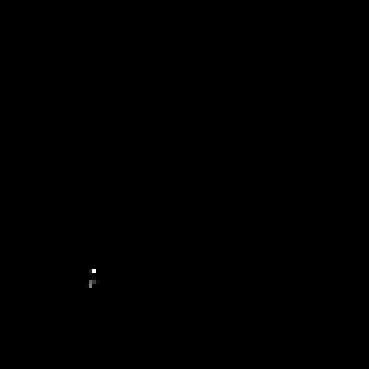

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(signal[7000])

In [ ]:
#FORMING SEPERATE BATCHES FOR TRAINING, TESTING AND VALIDATION
train_batches = ImageDataGenerator(rescale=1./255,horizontal_flip=True,
                             vertical_flip=True,shear_range=0.1,
                             zoom_range=0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1).flow_from_directory('/content/master_data/train',
                                                    target_size = (224, 224),
                                                    class_mode = 'binary',
                                                    batch_size = 16,
                                                    color_mode='grayscale')

test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory('/content/master_data/test',
                                                    target_size = (224,224),
                                                    class_mode = 'binary',
                                                    batch_size = 16, color_mode='grayscale')
val_batches = ImageDataGenerator(rescale=1./255).flow_from_directory('/content/master_data/val',
                                                    target_size = (224, 224),
                                                    class_mode = 'binary',
                                                    batch_size = 16, color_mode='grayscale')


Found 10410 images belonging to 2 classes.
Found 3470 images belonging to 2 classes.
Found 3470 images belonging to 2 classes.


In [ ]:
class Maxout(tf.keras.layers.Layer):
    def __init__(self, num_units=5):
        super(Maxout, self).__init__()
        self.num_units = num_units

    def build(self, input_shape):
        self.fc = tf.keras.layers.Dense(input_shape[-1] * self.num_units)

    def call(self, x):
        out = self.fc(x)
        out = tf.reshape(out, [-1, x.shape[-1], self.num_units])
        out = tf.reduce_max(out, axis=2)
        return out

In [ ]:
from keras.layers import Layer
import keras.backend as K

class LocalResponseNormalization(Layer):
    def __init__(self, alpha=1e-4, beta=0.75, k=2, **kwargs):
        self.alpha = alpha
        self.beta = beta
        self.k = k
        super(LocalResponseNormalization, self).__init__(**kwargs)

    def build(self, input_shape):
        super(LocalResponseNormalization, self).build(input_shape)

    def call(self, x):
        squared = K.square(x)
        pooled = K.pool2d(squared, (self.k, self.k), padding="same", pool_mode="avg")
        normalized = x / K.pow((self.alpha * pooled + 1.0), self.beta)
        return normalized

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
#Create a Sequential model
model = Sequential()


# Add the first Convolutional layer with L2 regularization
#model.add(ZeroPadding2D(5, data_format="channels_first"))
model.add(Conv2D(32, (11, 11), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(224, 224, 1)))

# Add the first MaxPooling layer
model.add(MaxPooling2D(2, 2))

# Add the second layer: Dropout
model.add(Dropout(0.2))

# Add the second Convolutional layer with L2 regularization
# model.add(ZeroPadding2D(1, data_format="channels_first"))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

# Add the second MaxPooling layer
model.add(MaxPooling2D(3, 3))

model.add(Dropout(0.2))
# Add the third Convolutional layer with L2 regularization
# model.add(ZeroPadding2D(1, data_format="channels_first"))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

# Add the third MaxPooling layer
model.add(MaxPooling2D(3, 3))

# Add Local Response Normalization
model.add(LocalResponseNormalization())

# Flatten the output before the Fully Connected layer
model.add(Flatten())

# Add a Dropout layer before the first Fully Connected layer
model.add(Dropout(0.2))
model.add(Dense(256, activation=Maxout()))
model.add(Dropout(0.2))
model.add(Dense(128, activation=Maxout()))
# Add the Fully Connected layer with 64 units
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.1))
# Add a Dropout layer before the output layer
model.add(Dropout(0.1))

# Add the output layer with a Sigmoid activation
model.add(Dense(1, activation='sigmoid'))


# Compiling the network
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', 'AUC'])
model.summary()
# model.save_weights('model.h5')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 214, 214, 32)      3904      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 107, 107, 32)      0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 107, 107, 32)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 105, 105, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 35, 35, 32)        0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 35, 35, 32)       

In [ ]:
# #FITTING THE MODEL
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=10,
                                        restore_best_weights=True)

history= model.fit(train_batches, steps_per_epoch=len(train_batches),
                    validation_data=val_batches, validation_steps=len(val_batches), epochs=5, verbose=1, callbacks=[earlystopping])

Epoch 1/5
651/651 [==============================] - 74s 105ms/step - loss: 0.7129 - accuracy: 0.5772 - auc: 0.5030 - val_loss: 0.7044 - val_accuracy: 0.5764 - val_auc: 0.5000
Epoch 2/5
651/651 [==============================] - 70s 108ms/step - loss: 0.6832 - accuracy: 0.5764 - auc: 0.5000 - val_loss: 0.6814 - val_accuracy: 0.5764 - val_auc: 0.5000
Epoch 3/5
651/651 [==============================] - 73s 111ms/step - loss: 0.6823 - accuracy: 0.5763 - auc: 0.5055 - val_loss: 0.6821 - val_accuracy: 0.5764 - val_auc: 0.5000
Epoch 4/5
651/651 [==============================] - 68s 104ms/step - loss: 0.6818 - accuracy: 0.5764 - auc: 0.5030 - val_loss: 0.6818 - val_accuracy: 0.5764 - val_auc: 0.5000
Epoch 5/5
651/651 [==============================] - 70s 107ms/step - loss: 0.6818 - accuracy: 0.5764 - auc: 0.4967 - val_loss: 0.6815 - val_accuracy: 0.5764 - val_auc: 0.5000


In [ ]:
# Let’s evaluate our model performance
score = model.evaluate(val_batches)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

217/217 [==============================] - 4s 18ms/step - loss: 0.6815 - accuracy: 0.5764 - auc: 0.5000
Test loss: 0.6814618706703186
Test accuracy: 0.5763688683509827


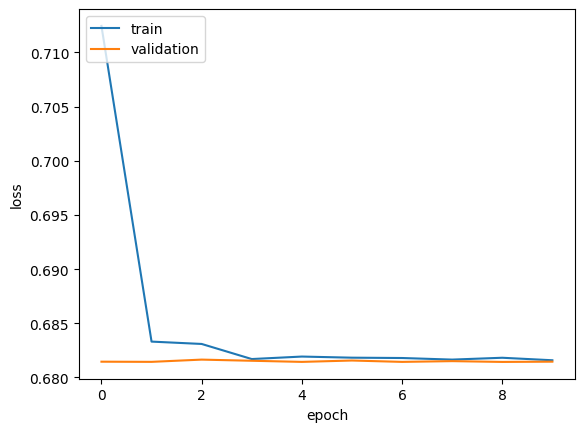

In [ ]:
# print(model.predict(test_batches))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.save_weights('my_model_weights.h5')
#model.load_weights('my_model_weights.h5')

In [ ]:
loss, accuracy, AUC = model.evaluate(test_batches, batch_size=16)
print('loss:',loss)
print('accuracy:', accuracy)
print('AUC:', AUC)

217/217 [==============================] - 5s 24ms/step - loss: 0.6815 - accuracy: 0.5764 - auc: 0.5000
loss: 0.6814614534378052
accuracy: 0.5763688683509827
AUC: 0.5


In [ ]:
y_pred = model.predict(test_batches)
# print(y_pred)
y_pred = np.argmax(y_pred, axis=1)
print(y_pred)
# y_test = np.argmax(y_test, axis=1)
# target_names = ['background', 'signal']
# print(classification_report(y_test, y_pred, target_names=target_names))
# print(y_test)
print(len(y_pred))

217/217 [==============================] - 4s 18ms/step
[0 0 0 ... 0 0 0]
3470


In [ ]:
from tensorflow.keras.preprocessing import image
def CNN_model_testing(path):
  img = image.load_img(path, target_size=(64,64),color_mode = "grayscale")
  img = image.img_to_array(img, dtype=np.uint8)
  img=img.reshape(64,64,1)
  img = np.array(img)/255.0
  p = model.predict(img)
  predicted_class = np.argmax(p[0])
  return img, p, predicted_class

signal, s_names = load_images_from_folder('/content/master_data/test/signal')
print("Results for", len(signal)," signal images")
for img in s_names:
  i, p, predicted_class = CNN_model_testing('/content/master_data/test/signal/'+img)
  print("Predicted Class", predicted_class, 'probability:', p)

bg, bg_names = load_images_from_folder('/content/master_data/test/bg')
print("Results for", len(bg)," Background images")
for img in s_names:
  i, p, predicted_class = CNN_model_testing('/content/master_data/test/bg/'+img)
  print("Predicted Class", predicted_class, 'probability:', p)

Results for 31  signal images


ValueError: ignored